最尤推定 ξ: -0.023776601126437147 σ: 4.511054789697523 RV: 33.208375855680515
最尤推定 ξ: -0.65579575731004 σ: 6.545743597020564 RV: 18.215059019845526
9.0 %の確率で極値増加
最尤推定 ξ: 0.19409126167751545 σ: 3.2868396965420565 RV: 45.71496843502011
最尤推定 ξ: 0.6507369060065427 σ: 0.7809396072084505 RV: 66.13477577898901
66.0 %の確率で極値増加
最尤推定 ξ: 0.06525918181511625 σ: 2.6963610895716394 RV: 27.786098707011153
最尤推定 ξ: 0.19645205895248108 σ: 3.4108739533811994 RV: 47.386807845385945
77.5 %の確率で極値増加
最尤推定 ξ: 0.8112711207041925 σ: 1.494502494606524 RV: 243.95387245962533
最尤推定 ξ: 0.4294964756669253 σ: 1.2415371850064116 RV: 43.7231568333703
30.5 %の確率で極値増加
最尤推定 ξ: -0.09021618157903566 σ: 2.4353629290023466 RV: 21.29096808517043
最尤推定 ξ: -0.04569829010825899 σ: 1.9378003426479413 RV: 19.6855103659804
32.7 %の確率で極値増加
最尤推定 ξ: -0.45175542140231306 σ: 2.667619651895826 RV: 15.210683986820563
最尤推定 ξ: -0.0696435196114798 σ: 1.6803072003649018 RV: 17.920407473979274
98.2 %の確率で極値増加


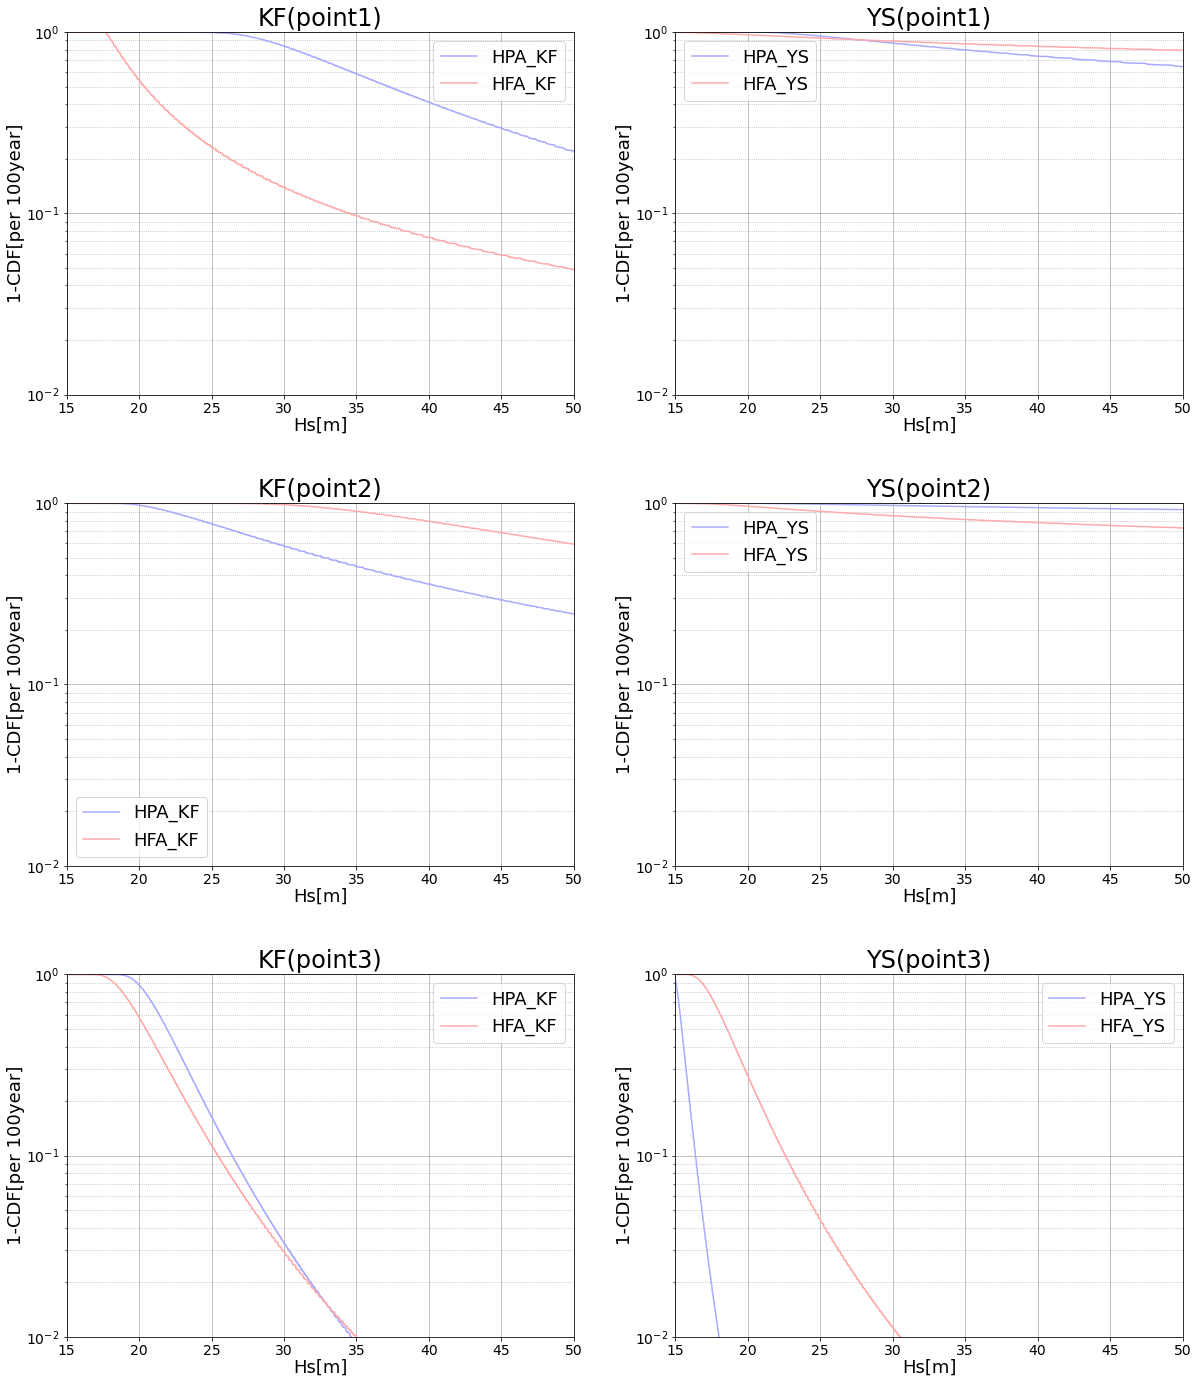

In [2]:
"""
LWMの出力結果を用いて, 極値増大確率を算出する.

"""

import func
from csv import reader
import matplotlib.pyplot as plt

MODEL = ['KF', 'YS']
INDEX = [79*67 + 13, 79*51 + 39, 79*21 + 75]

def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    将来分布の中で, hsより大きい値を取る確率を合計する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def cdf(rv, pro):
    Hs = []
    SUM = []
    sum = 1
    s = [(rv[i], pro[i]) for i in range(len(rv))]
    s.sort()
    for i in range(len(rv)):
        sum -= s[i][1]
        SUM.append(sum)
        Hs.append(s[i][0])
    return Hs, SUM

# 描画用の画像を用意
fig = plt.figure(figsize=(20, 24))
for index in range(len(INDEX)):
    idx = INDEX[index]
    for i in range(2):
        is_ok = True  # データ数が50以上あるかどうかのFlag(なければその地点は使用しない)
        for j in range(2):
            model = MODEL[i]
            # CSV名を指定するためにmodel名を変更
            if j == 0:  # 過去
                model = 'HPA_' + model
            else:  # 未来
                model = 'HFA_' + model + '_c0'
            with open('../pot_csv(100)(thr=8)/' + model + '_POT_DATA.csv', 'r') as csv_file:
                csv_reader = reader(csv_file)
                POT_ALL = list(csv_reader)
            POT = POT_ALL[idx] # 指定した場所のPOTを抽出
            # POTは文字列のリストになっているので, float型に変換する
            s = []
            for k in range(len(POT)):
                s.append(float(POT[k]))
            s = sorted(s, reverse=True)
            if len(POT) < 10:
                is_ok = False
                print("データ数：", len(POT), "データ数が不足しているため, この地点は使用できません")
            else:
                POT = s[:100]
                if j == 0:  # 過去
                    past_rv, past_pro = func.lwm_gpd(data=POT, error=[0.005], thr=POT[-1], n=219143, n0=100, con=1.0)
                else:  # 将来
                    f_rv, f_pro = func.lwm_gpd(data=POT, error=[0.005], thr=POT[-1], n=219143, n0=100, con=1.0)
        
        if is_ok:
            P = calc_p(past_rv, past_pro, f_rv, f_pro)
            cdf_p_hs, cdf_p_sum = cdf(past_rv, past_pro)
            cdf_f_hs, cdf_f_sum = cdf(f_rv, f_pro)
            print('{:.1f}'.format(P), '%の確率で極値増加')
            ax = fig.add_subplot(3, 2, 2 * index + i+1)
            ax.plot(cdf_p_hs, cdf_p_sum, c='#aaaaFF')
            ax.plot(cdf_f_hs, cdf_f_sum, c='#FFaaaa')
            ax.legend(['HPA_' + model[4:6], model[:-3]], fontsize=18)
            ax.set_xlim((15, 50))
            ax.set_ylim((0.01, 1))
            ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
            ax.set_ylabel("1-CDF[per 100year]", fontsize=18, labelpad=1)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_title(MODEL[i] + '(point' + str(index+1) + ')', fontsize=24)
            ax.set_yscale('log')
            ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
            ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

plt.subplots_adjust(hspace=0.3)
# plt.savefig("../img/cdf.png")
plt.show()

HPA_KF
POTデータの範囲 21.850000305175783 ~ 24.16000030517578
[24.16000030517578, 24.16000030517578, 24.16000030517578, 24.16000030517578, 24.15000030517578, 24.15000030517578, 24.140000305175782, 24.13000030517578, 24.13000030517578, 24.120000305175783, 24.100000305175783, 24.100000305175783, 24.100000305175783, 24.09000030517578, 24.070000305175782]
最尤推定 ξ: -1.3583015749890388 σ: 3.143059007397432 RV: 24.163286235795457
HFA_KF_c0
POTデータの範囲 21.190000305175783 ~ 24.16000030517578
[24.16000030517578, 24.16000030517578, 24.16000030517578, 24.16000030517578, 24.16000030517578, 24.16000030517578, 24.15000030517578, 24.140000305175782, 24.120000305175783, 24.11000030517578, 24.09000030517578, 24.02000030517578, 24.02000030517578, 23.980000305175782, 23.980000305175782]
最尤推定 ξ: -1.0581430643148626 σ: 3.1481888299295364 RV: 24.159948110900892
77.87090975009183 %の確率で極値増加
HPA_YS
POTデータの範囲 20.350000305175783 ~ 24.16000030517578
[24.16000030517578, 24.16000030517578, 24.16000030517578, 24.1600003051757

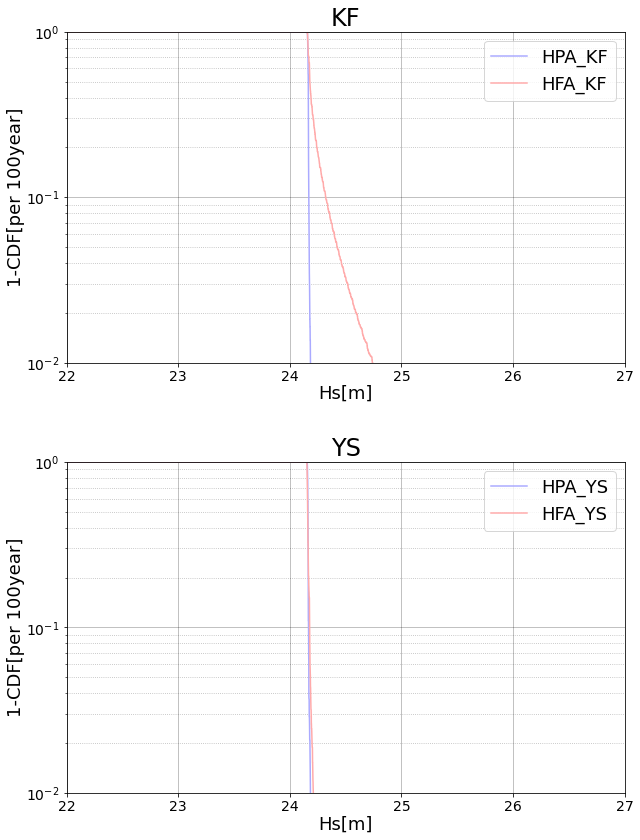

In [5]:
"""
LWMの出力結果を用いて, 極値増大確率を算出する.

"""

import func
from csv import reader
import matplotlib.pyplot as plt

def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    将来分布の中で, hsより大きい値を取る確率を合計する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def cdf(rv, pro):
    Hs = []
    SUM = []
    sum = 1
    s = [(rv[i], pro[i]) for i in range(len(rv))]
    s.sort()
    for i in range(len(rv)):
        sum -= s[i][1]
        SUM.append(sum)
        Hs.append(s[i][0])
    return Hs, SUM

# 描画用の画像を用意
fig = plt.figure(figsize=(10, 14))

MODEL = ['KF', 'YS']
DATA_CNT = 100

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'
        
        print(model)

        with open('../pot_csv/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0
        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[1] == 24.170000305175783:  #この値は欠損地扱い
                continue
            if data[0] > last_index + 24 * 7:
                EVENT_POT.append([data[0], data[1]])
                last_index = data[0]
                max_val = data[1]
            else:
                if data[1] > max_val:
                    EVENT_POT[-1] = [data[0], data[1]]
                    last_index = data[0]
                    max_val = data[1]

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(pot[1])
        
        # 大きい順にsort
        POT_DATA.sort(reverse=True)
        POT_DATA = POT_DATA[:DATA_CNT]
        print('POTデータの範囲', POT_DATA[-1], '~', POT_DATA[0])
        print(POT_DATA[:15])
        
        if num == 0:
            past_rv, past_pro = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=DATA_CNT, con=1.0)
        else:
            f_rv, f_pro = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=DATA_CNT, con=1.0)
        
    P = calc_p(past_rv, past_pro, f_rv, f_pro)
    cdf_p_hs, cdf_p_sum = cdf(past_rv, past_pro)
    cdf_f_hs, cdf_f_sum = cdf(f_rv, f_pro)
    print(P, '%の確率で極値増加')
    ax = fig.add_subplot(2, 1, model_num + 1)
    ax.plot(cdf_p_hs, cdf_p_sum, c='#aaaaFF')
    ax.plot(cdf_f_hs, cdf_f_sum, c='#FFaaaa')
    ax.legend(['HPA_' + model[4:6], model[:-3]], fontsize=18)
    ax.set_xlim((22, 27))
    ax.set_ylim((0.01, 1))
    ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
    ax.set_ylabel("1-CDF[per 100year]", fontsize=18, labelpad=1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(MODEL[model_num], fontsize=24)
    ax.set_yscale('log')
    ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
    ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

plt.subplots_adjust(hspace=0.3)
plt.savefig("../img/cdf_of_tc.png")
plt.show()

HPA_KF
POTデータの範囲 20.510000305175783 ~ 24.16000030517578
[24.16000030517578, 24.15000030517578, 24.140000305175782, 24.13000030517578, 24.120000305175783, 24.100000305175783, 24.09000030517578, 24.070000305175782, 24.050000305175782, 24.04000030517578, 24.030000305175783, 24.02000030517578, 23.990000305175784, 23.97000030517578, 23.95000030517578]
最尤推定 ξ: -1.0675862534147242 σ: 3.9025276762018786 RV: 24.159368683837574
HFA_KF_c0
POTデータの範囲 20.260000305175783 ~ 24.16000030517578
[24.16000030517578, 24.15000030517578, 24.140000305175782, 24.120000305175783, 24.11000030517578, 24.09000030517578, 24.02000030517578, 23.980000305175782, 23.920000305175783, 23.870000305175783, 23.86000030517578, 23.84000030517578, 23.690000305175783, 23.66000030517578, 23.61000030517578]
最尤推定 ξ: -0.9495463896664528 σ: 3.7136013855741035 RV: 24.15768534716887
75.64757851799634 %の確率で極値増加
HPA_YS
POTデータの範囲 20.04000030517578 ~ 24.16000030517578
[24.16000030517578, 24.15000030517578, 24.140000305175782, 24.1000003051

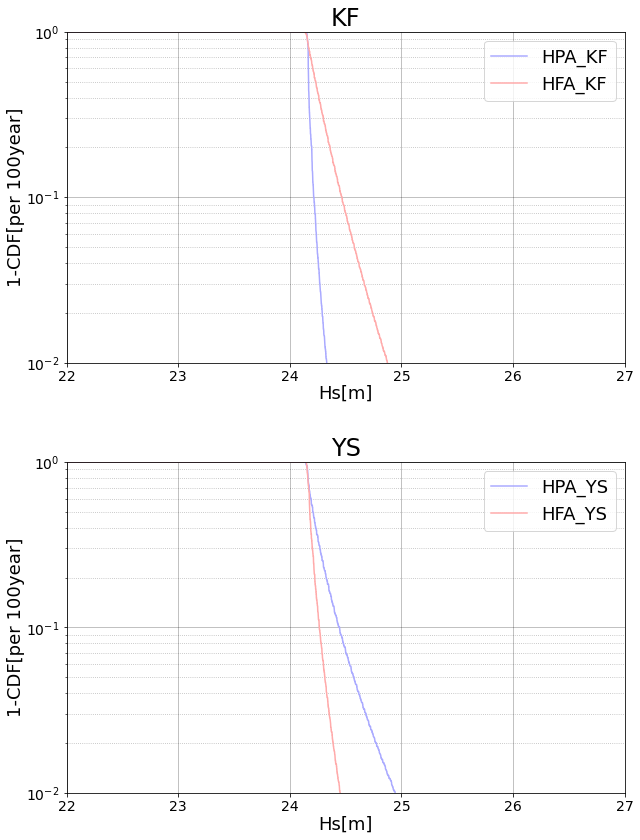

In [6]:
"""
LWMの出力結果を用いて, 極値増大確率を算出する.
重複は削除する.

"""

import func
from csv import reader
import matplotlib.pyplot as plt

def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    将来分布の中で, hsより大きい値を取る確率を合計する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def cdf(rv, pro):
    Hs = []
    SUM = []
    sum = 1
    s = [(rv[i], pro[i]) for i in range(len(rv))]
    s.sort()
    for i in range(len(rv)):
        sum -= s[i][1]
        SUM.append(sum)
        Hs.append(s[i][0])
    return Hs, SUM

# 描画用の画像を用意
fig = plt.figure(figsize=(10, 14))

MODEL = ['KF', 'YS']
DATA_CNT = 100

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'
        
        print(model)

        with open('../pot_csv/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0
        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[1] == 24.170000305175783:  #この値は欠損地扱い
                continue
            if data[0] > last_index + 24 * 7:
                EVENT_POT.append([data[0], data[1]])
                last_index = data[0]
                max_val = data[1]
            else:
                if data[1] > max_val:
                    EVENT_POT[-1] = [data[0], data[1]]
                    last_index = data[0]
                    max_val = data[1]

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(pot[1])
        
        # 大きい順にsort
        POT_DATA = list(set(POT_DATA))
        POT_DATA.sort(reverse=True)
        POT_DATA = POT_DATA[:DATA_CNT]
        print('POTデータの範囲', POT_DATA[-1], '~', POT_DATA[0])
        print(POT_DATA[:15])
        
        if num == 0:
            past_rv, past_pro = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=DATA_CNT, con=1.0)
        else:
            f_rv, f_pro = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=DATA_CNT, con=1.0)
        
    P = calc_p(past_rv, past_pro, f_rv, f_pro)
    cdf_p_hs, cdf_p_sum = cdf(past_rv, past_pro)
    cdf_f_hs, cdf_f_sum = cdf(f_rv, f_pro)
    print(P, '%の確率で極値増加')
    ax = fig.add_subplot(2, 1, model_num + 1)
    ax.plot(cdf_p_hs, cdf_p_sum, c='#aaaaFF')
    ax.plot(cdf_f_hs, cdf_f_sum, c='#FFaaaa')
    ax.legend(['HPA_' + model[4:6], model[:-3]], fontsize=18)
    ax.set_xlim((22, 27))
    ax.set_ylim((0.01, 1))
    ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
    ax.set_ylabel("1-CDF[per 100year]", fontsize=18, labelpad=1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(MODEL[model_num], fontsize=24)
    ax.set_yscale('log')
    ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
    ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

plt.subplots_adjust(hspace=0.3)
plt.savefig("../img/cdf_of_tc_2.png")
plt.show()